### 1. Read Data

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn import decomposition, preprocessing, cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [3]:
### Read Training Data and Testing Data
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")
train.shape

(188318, 132)

In [4]:
### Drop id and Seperate loss
train_id = train['id']
test_id =  test['id']
train_label = train['loss']
train.drop('id',axis=1,inplace=True)
train.drop('loss',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)
print (train.shape, test.shape)

(188318, 130) (125546, 130)


### 2. Exploratory Analysis
    
    -Target Variable - loss
    -Categorical Variables
    -Continuous Variables

#### 2.1 Target Variable - loss

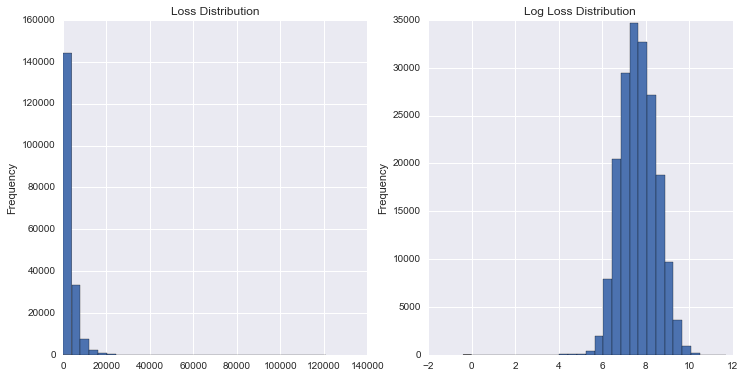

In [5]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.set_title("Loss Distribution")
train_label.plot(kind='hist', grid = True, bins=30)

ax1 = fig.add_subplot(122)
ax1.set_title("Log Loss Distribution")
np.log(train_label).plot(kind='hist', grid = True, bins=30)

In [6]:
### Let's remove outliers!
train_label_log = np.log(train_label)
print("We have %d outliers." % (train_label_log[train_label_log<4].count()))
train_new = train.drop(train_label_log[train_label_log<4].index)
label_new = train_label_log.drop(train_label_log[train_label_log<4].index)
train_new = train_new.reset_index(drop=True)
label_new = label_new.reset_index(drop=True)

We have 17 outliers.


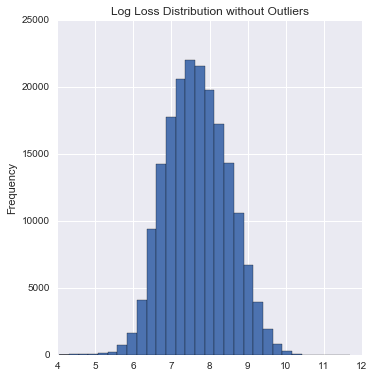

In [7]:
### Plot log loss without outliers
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.set_title("Log Loss Distribution without Outliers")
label_new.plot(kind='hist', grid = True, bins=30)

#### 2.2 Categorical Variables

In [8]:
### Check number of categorical variables
features = train_new.columns
cats = [feat for feat in features if 'cat' in feat]
print("We have %d categorical variables." % (len(cats)))

We have 116 categorical variables.


In [9]:
### Check how many categories we have in each
unique = {'2':0,'2 to 10':0,'10 to 20':0, 'more than 20':0}
for i in range(len(cats)):
    count = len(train_new[cats[i]].unique())
    if count <= 2:
        unique["2"] += 1
    elif count <= 10:
        unique['2 to 10'] += 1
    elif count <=20:
        unique['10 to 20'] += 1
    else:
        unique['more than 20'] += 1

for k, v in unique.items():
    print ("%d variables has %s categories." % (v, k))

27 variables has 2 to 10 categories.
6 variables has more than 20 categories.
72 variables has 2 categories.
11 variables has 10 to 20 categories.


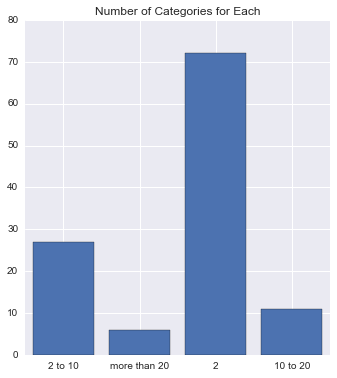

In [10]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.set_title("Number of Categories for Each")
plt.bar(range(len(unique)), unique.values(), align='center')
plt.xticks(range(len(unique)), unique.keys(), fontsize=10)
plt.show() 

#### 2.3 Continuous Variables

In [11]:
conts = [feat for feat in features if 'cont' in feat]
print("We have %d numeric variables." % (len(conts)))
print(train[conts].skew())

We have 14 numeric variables.
cont1     0.516424
cont2    -0.310941
cont3    -0.010002
cont4     0.416096
cont5     0.681622
cont6     0.461214
cont7     0.826053
cont8     0.676634
cont9     1.072429
cont10    0.355001
cont11    0.280821
cont12    0.291992
cont13    0.380742
cont14    0.248674
dtype: float64


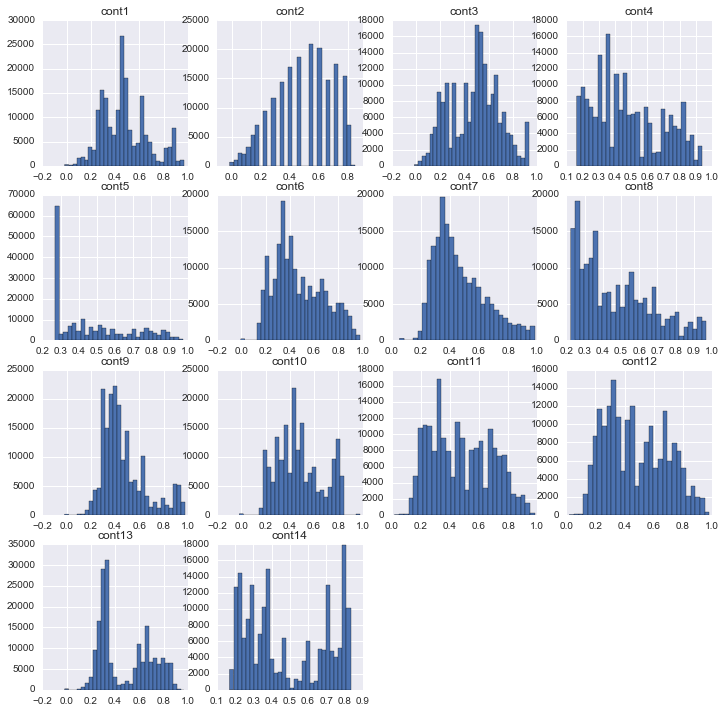

In [12]:
### Plot the distributions
fig = plt.figure(figsize=(12,12))
for i in range(14):
    #position
    ax1 = fig.add_subplot(4,4,1+i)
    ax1.set_title(conts[i])
    ax1.hist(train[conts[i]], align='left',bins = 30)

In [13]:
"""### Plot the distributions
fig = plt.figure(figsize=(12,12))
for i in range(14):
    #position
    ax1 = fig.add_subplot(4,4,1+i)
    ax1.set_title(conts[i])
    ax1.hist(np.log(train[conts[i]]), align='left',bins = 30)"""

"### Plot the distributions\nfig = plt.figure(figsize=(12,12))\nfor i in range(14):\n    #position\n    ax1 = fig.add_subplot(4,4,1+i)\n    ax1.set_title(conts[i])\n    ax1.hist(np.log(train[conts[i]]), align='left',bins = 30)"

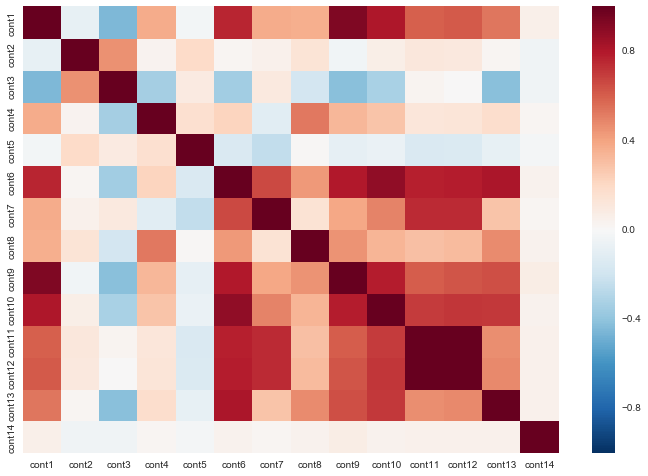

In [14]:
### Correlation Plot
fig = plt.figure(figsize=(12,8))
corr = train[conts].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [15]:
### Standardize Continuous Variables

### 3. Data Preprocessing

#### 3.1 One Hot Dummy Encoding

In [16]:
### Let's merge the training and testing data 
train_new['label'] = 'train'
test['label'] = 'test'
frames = [train_new,test] 
df_all = pd.concat(frames)
df_all = df_all.reset_index(drop=True)
print(df_all.shape)
df_all.head()

(313847, 131)


,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,label
0,A,B,A,B,A,A,A,A,B,A,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,train
1,A,B,A,A,A,A,A,A,B,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,train
2,A,B,A,A,B,A,A,A,B,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,train
3,B,B,A,B,A,A,A,A,B,A,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,train
4,A,B,A,B,A,A,A,A,B,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,train


In [17]:
### One hot dummy encoding
### Column 0-115(index) are categorical, 116 - 129 are numeric
dummies = pd.get_dummies(df_all[cats])
dummies.shape

(313847, 1176)

#### 3.2 Normalize Numerical Variables

In [18]:
normalized = preprocessing.MinMaxScaler().fit(df_all[conts]).transform(df_all[conts])
normalized = pd.DataFrame(normalized,columns=conts)
print(normalized.shape)
normalized.head()

(313847, 14)


,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.737375,0.284121,0.196416,0.786418,0.041163,0.716810,0.285393,0.088106,0.674426,0.839313,0.554715,0.580320,0.832028,0.804879
1,0.335545,0.854225,0.626632,0.561159,0.860732,0.432954,0.394501,0.487975,0.352841,0.441406,0.314495,0.343023,0.618460,0.189002
2,0.265823,0.414588,0.511420,0.077013,0.165012,0.281332,0.264420,0.048692,0.261906,0.326097,0.359217,0.350420,0.197802,0.894304
3,0.326489,0.643795,0.557931,0.252713,0.200881,0.435014,0.345649,0.108698,0.322710,0.446914,0.303703,0.296531,0.612031,0.636480
4,0.277360,0.184376,0.557931,0.380274,0.602287,0.168119,0.191194,0.011744,0.221848,0.213371,0.175796,0.172492,0.248701,0.381278


#### 3.3 Split the data back to training and testing

In [20]:
df_new = pd.concat((dummies,normalized,df_all.label),axis=1)
new_train = df_new[df_new.label=='train']
new_test = df_new[df_new.label=='test']
print("Shape of the new training set: ", new_train.shape)
print("Shape of the new test set: ", new_test.shape)

Shape of the new training set:  (188301, 1191)
Shape of the new test set:  (125546, 1191)


In [21]:
del train, test, train_new, df_all

In [ ]:
### Some formatting
new_train.drop('label',axis=1, inplace=True)
new_test.drop('label',axis=1, inplace=True)
new_train = new_train.reset_index(drop=True)
new_test = new_test.reset_index(drop=True)

### 4. Dimensioanality Reduction
    - Train and Test Split
    - Feature Selection
    - PCA

#### 4.1 Train and Test Split

In [36]:
#### 4.1 Train and Test Split
train_x = new_train.sample(frac=0.1, replace=False)
train_y = label_new[train_x.index]
### 80% - 20% train and test split
X_train, X_test,y_train, y_test = cross_validation.train_test_split(X.values, Y.values, test_size=0.2, random_state=50)

In [41]:
X_train.shape

(15064, 1190)

### Please see the other scripts for the dimensionality reduction and data modeling!
### Thank you!